## Install master branches of theano and lasagne
[Here are the instructions](http://lasagne.readthedocs.io/en/latest/user/installation.html#bleeding-edge-version)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pymc3 as pm
import theano.tensor as tt
import theano

from scipy.stats import mode, chisquare
from sklearn.metrics import confusion_matrix, accuracy_score
import lasagne
import os


In [5]:
#(u'1.0.1', '0.2.dev1')
theano.__version__, lasagne.__version__


(u'1.0.1', '0.2.dev1')

### notMNIST images courtesy Y. Bulatov
[notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html)

In [15]:
#Extract tar file
basedir = 'data/notMNIST/'
localfile = os.path.join(basedir, 'notMNIST_small.tar.gz')
import tarfile
tar = tarfile.open(localfile)
tar.extractall()
tar.close()


## Preprocess notMNIST
Adapted from code by Y. Bulatov 
Source: http://yaroslavvb.com/upload/notMNIST/matlab_convert.py

data/notMNIST/notMNIST_small/
Found 18726 files
exception 'module' object has no attribute 'register_decoder'
exception 'module' object has no attribute 'register_decoder'


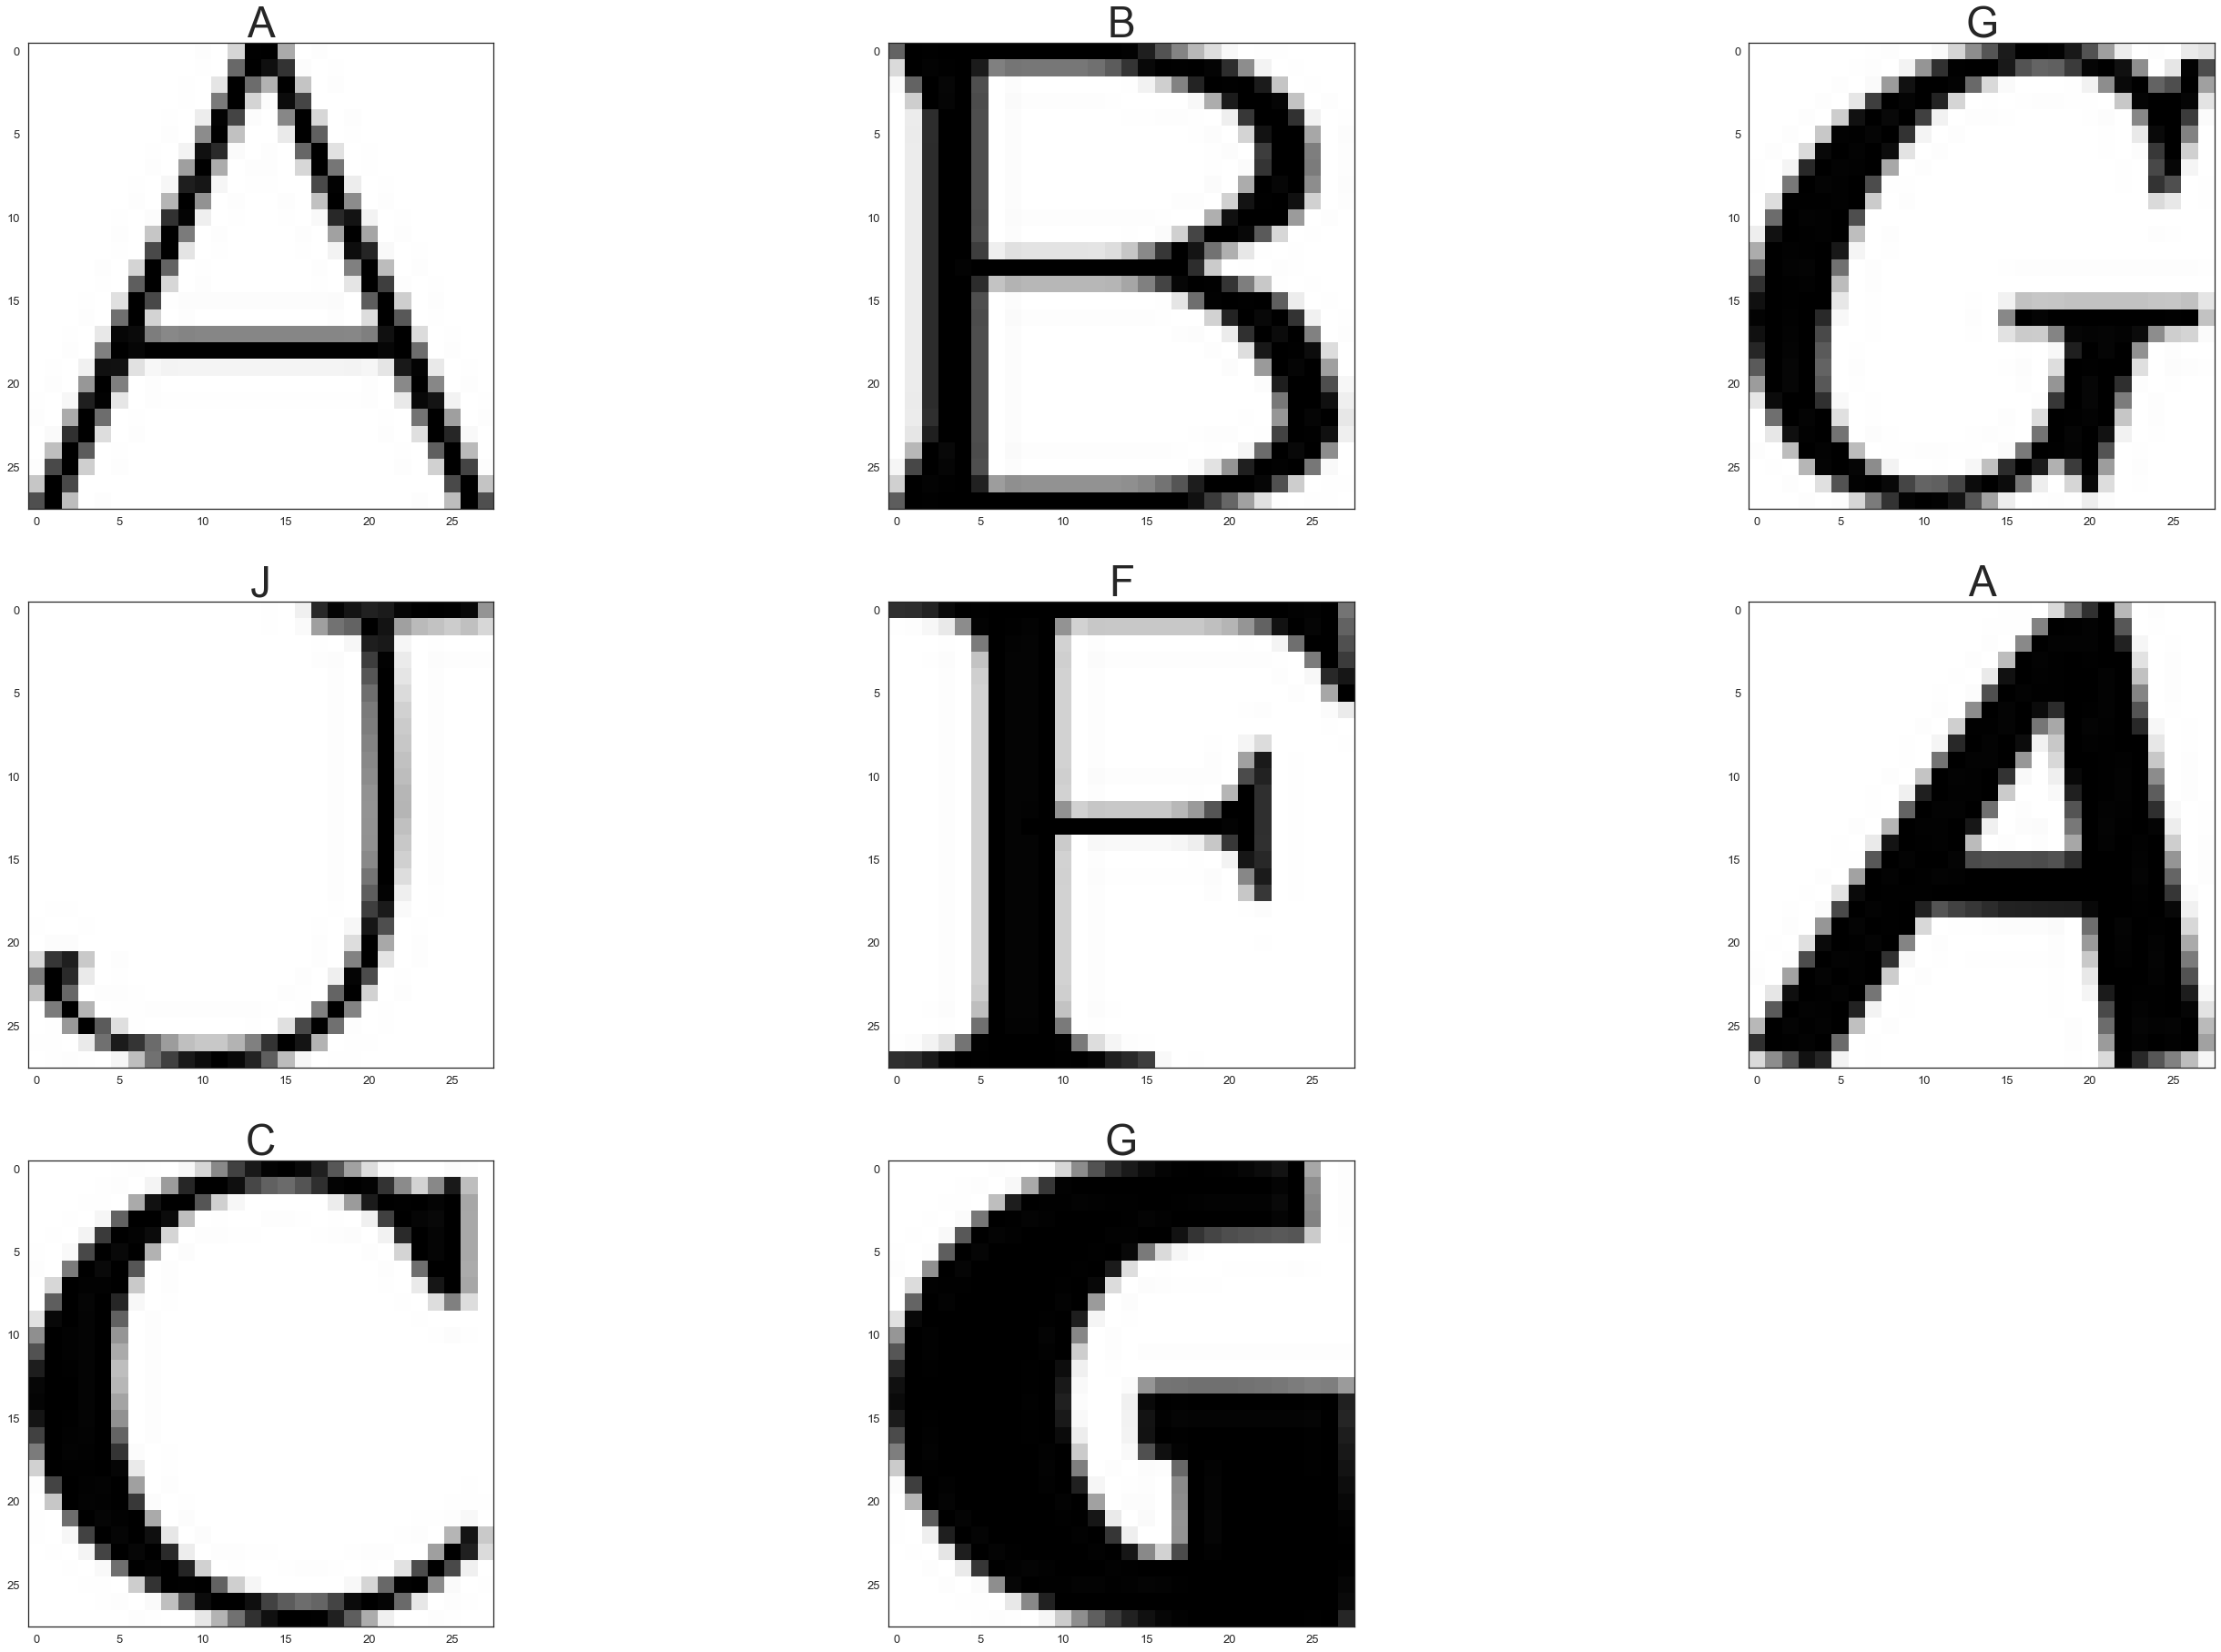

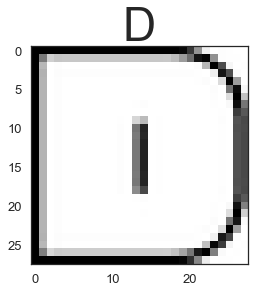

In [114]:
#!/usr/bin/python2.6
# Turns directory of notMNIST glyphs into train, test datasets
#
# dataset_dir --> A --> img1.png
#                   --> img2.png
#             --> B --> img1.png
#                   --> img2.png
#      ...
#             --> J --> img1.png
#                   --> img2.png
#
# Show some images with their labels
#   load('target.mat')
#   for i=1:5
#     figure('Name',num2str(labels(i))),imshow(images(:,:,i)/255)
#   end
#

%matplotlib inline

from scipy.io import savemat
import numpy as np, glob, sys, os
import PIL.Image as Image
from matplotlib.pyplot import imshow
from sklearn.cross_validation import train_test_split

def reshape_X(X_pre):
    X_post = np.zeros((X_pre.shape[0], 1, 28, 28))
    for i in range(X_pre.shape[0]):
        X_post[i, 0, :, :] = X_pre[i, :, :]
    return X_post

mapping = {}
def generate_dataset(folder):
    print folder
    max_count = 0
    for (root, dirs, files) in os.walk(folder):
        for f in files:
            if f.endswith('.png'):
                max_count+=1

    print 'Found %s files'%(max_count,)
    data = np.zeros((28,28,max_count))
    labels = np.zeros((max_count,))
    count = 0
    for (root, dirs, files) in os.walk(folder):
        for f in files:
            if f.endswith('.png'):
                try:
                    #print("opening {}, {}, {}".format(root, f, os.path.join(root, f)))
                    img = Image.open(os.path.join(root, f));
                    #print("{}, {}".format(f, dirs))
                    data[:,:,count]=np.asarray(img)
                    surround_folder = os.path.split(root)[-1]
                    assert len(surround_folder)==1
                    ordinal = ord(surround_folder)-ord('A')
                    labels[count]=ordinal
                    mapping[ordinal] = surround_folder
                    count+=1
                except Exception as e:
                    print("exception {}".format(e))
                    pass
    
    # Plot NUM samples
    fig = plt.figure()
    COLS, NUM = 3, 8
    np.random.seed(NUM)
    for i in range(NUM):
        ax = fig.add_subplot(COLS, np.ceil(NUM/float(COLS)), i + 1)
        x = np.random.randint(max_count)
        a0, c0 = data[:, :, x], labels[x]
        plt.imshow(a0)
        plt.title(mapping[c0], fontsize=46)
    fig.set_size_inches(np.array(fig.get_size_inches())*NUM)
    #print("data: {}, {}".format(data[:, :, :count].shape, labels[:count].shape))
    ndata = np.zeros((max_count, 28, 28))
    for i in range(max_count):
        ndata[i, :, :] = data[:, :, i]
    
    fig = plt.figure()
    x = np.random.randint(max_count)
    #print("ndata: {},{},{}".format(x, ndata[x].shape, ndata[x, :, :]))
    a0, c0 = ndata[x, :, :], labels[x]
    plt.imshow(a0)
    plt.title(mapping[c0], fontsize=46)
    
    X_train, X_test, y_train, y_test = train_test_split(ndata[:count], labels[:count], test_size=0.1)
    X_train, X_test = reshape_X(X_train), reshape_X(X_test)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = generate_dataset('data/notMNIST/notMNIST_small/')


data/notMNIST/notMNIST_small/
Found 18726 files
exception 'module' object has no attribute 'register_decoder'
exception 'module' object has no attribute 'register_decoder'


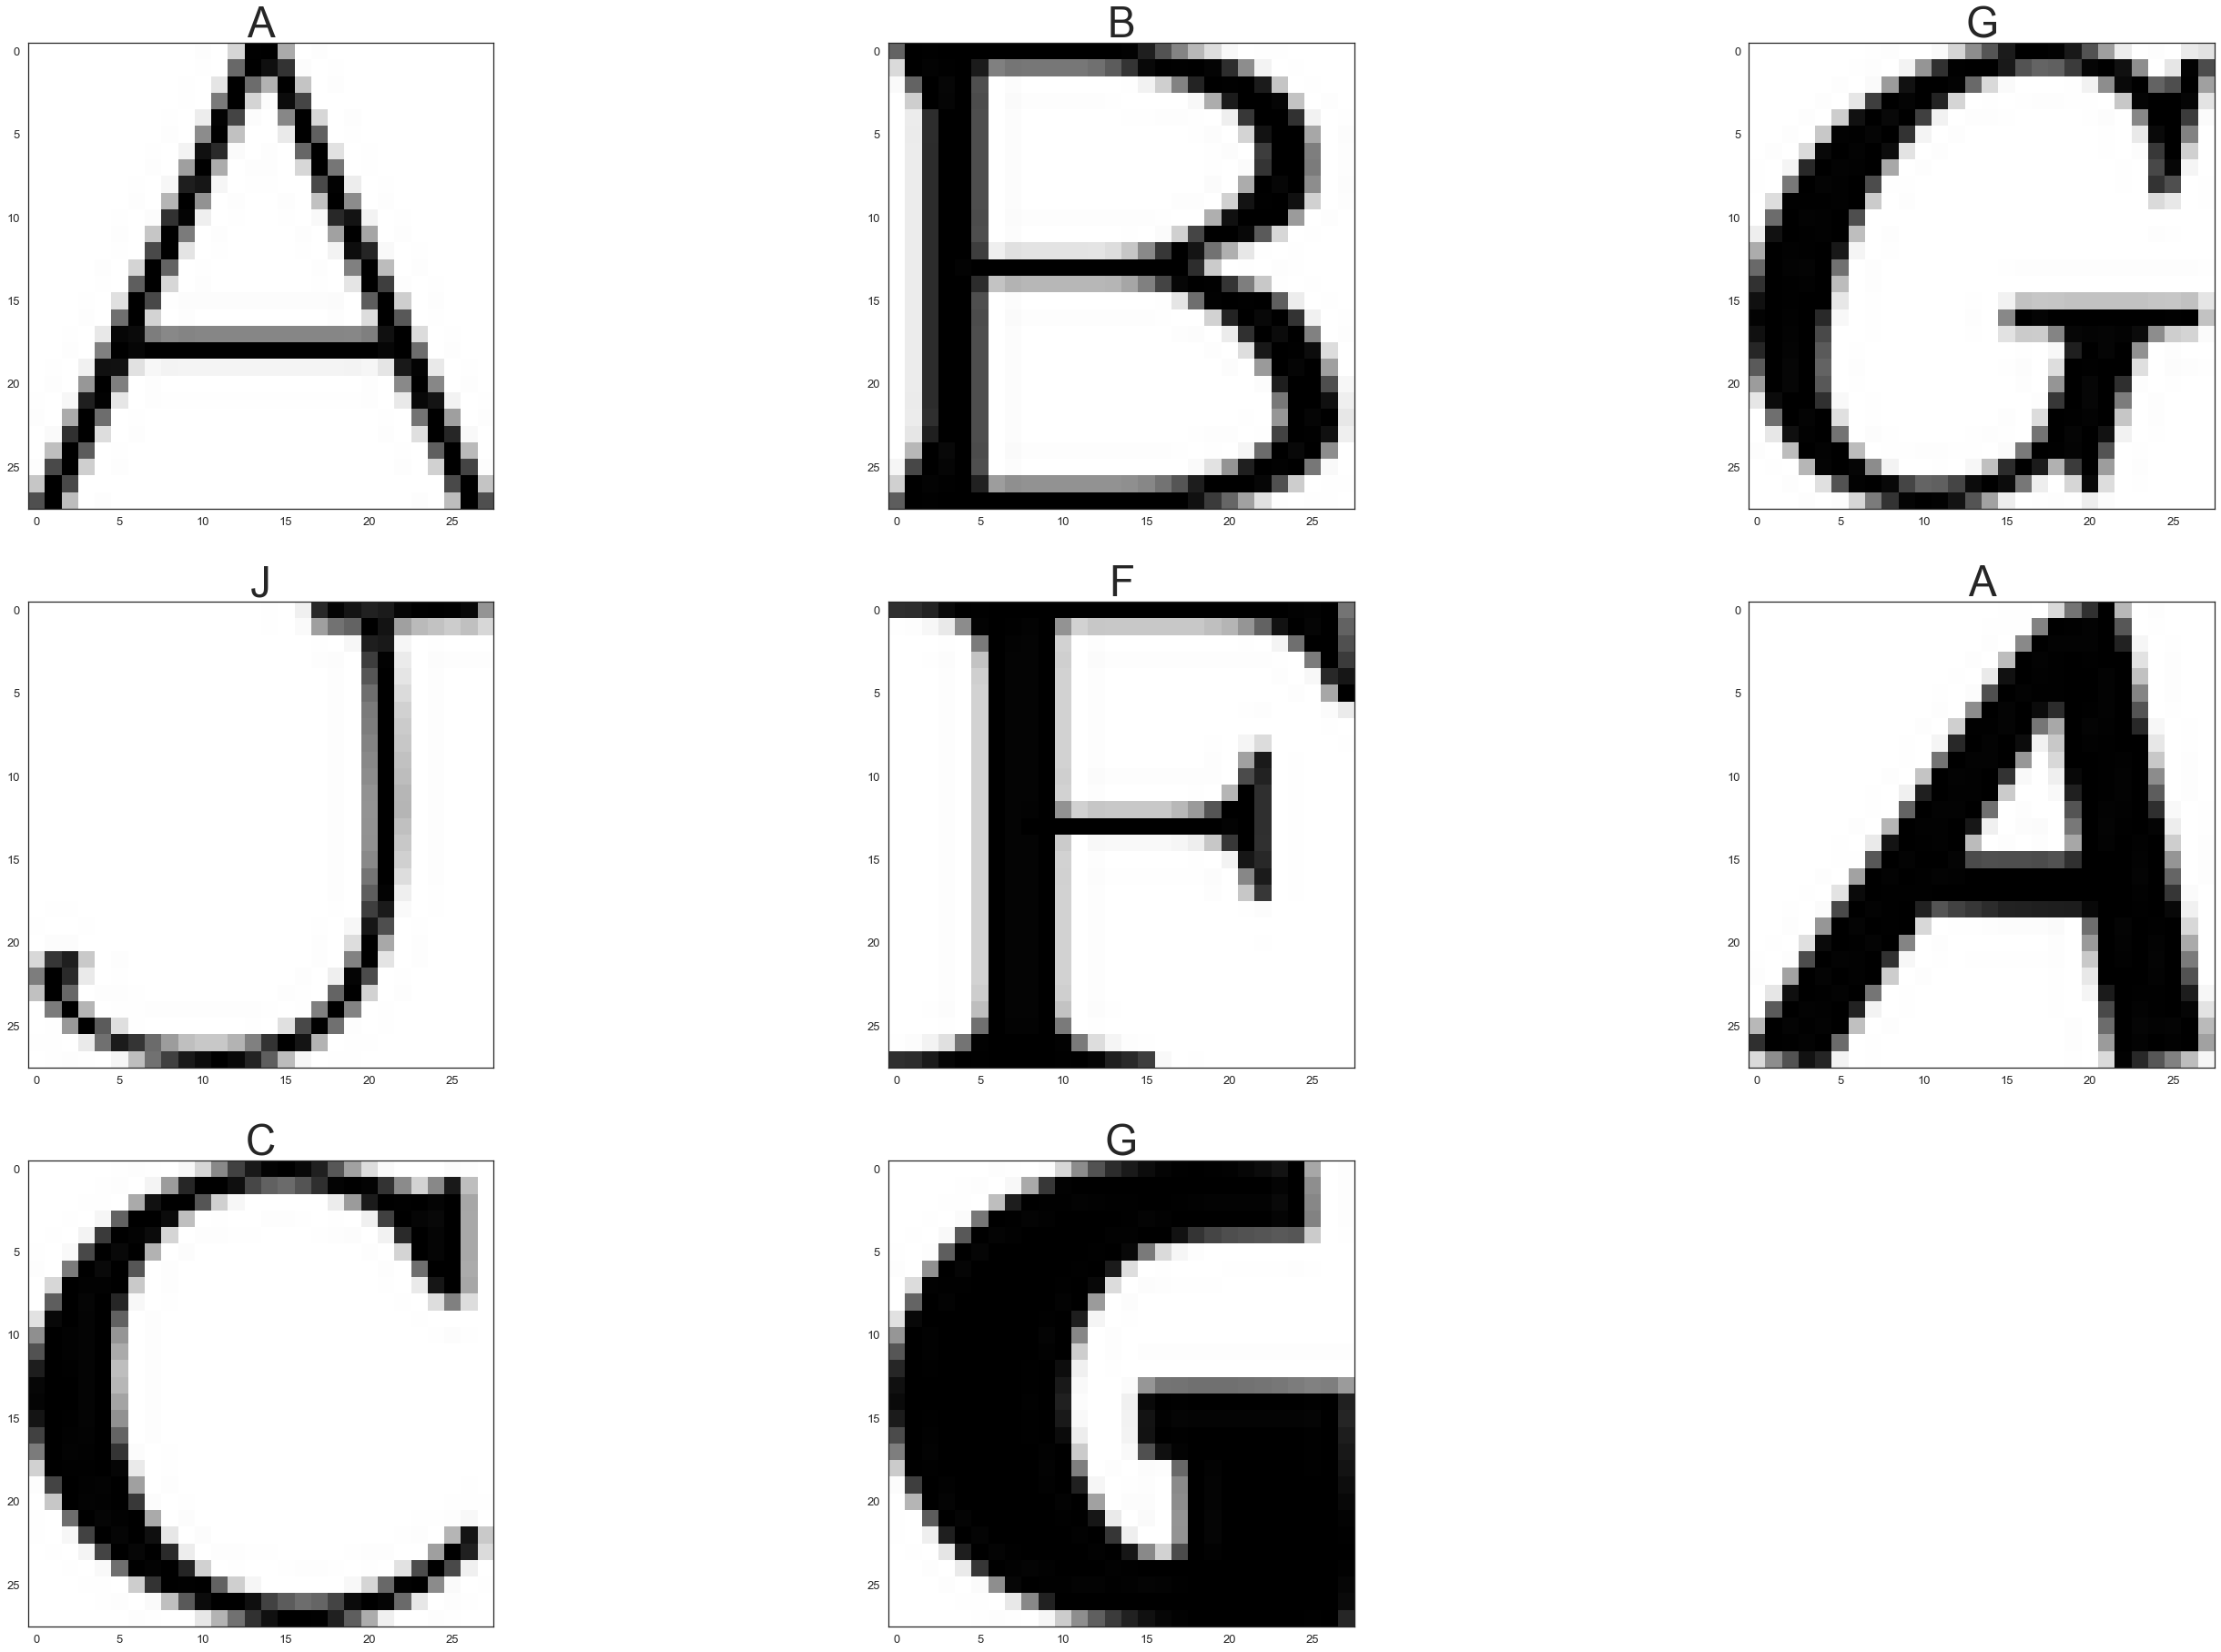

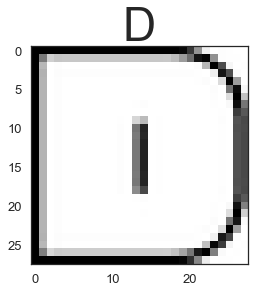

In [125]:
import sys, os
from scipy.io import savemat
import numpy as np, glob, sys, os
import PIL.Image as Image
from matplotlib.pyplot import imshow
from sklearn.cross_validation import train_test_split

def load_dataset():
    #support both python 2 and 3
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    basedir = 'data/notMNIST/'
    if not os.path.exists(basedir):
        os.makedirs(basedir)
        
    def download(filename, source='http://yaroslavvb.com/upload/notMNIST/'):
        localfile = os.path.join(basedir, filename)
        if not os.path.exists(localfile):
            print ("Downloading %s" % filename)
            urlretrieve(source + filename, localfile)

    def reshape_X(X_pre):
        X_post = np.zeros((X_pre.shape[0], 1, 28, 28))
        for i in range(X_pre.shape[0]):
            X_post[i, 0, :, :] = X_pre[i, :, :]
        return X_post

    mapping = {}

    def generate_dataset(folder):
        print folder
        max_count = 0
        for (root, dirs, files) in os.walk(folder):
            for f in files:
                if f.endswith('.png'):
                    max_count+=1

        print 'Found %s files'%(max_count,)
        data = np.zeros((28,28,max_count))
        labels = np.zeros((max_count,))
        count = 0
        for (root, dirs, files) in os.walk(folder):
            for f in files:
                if f.endswith('.png'):
                    try:
                        #print("opening {}, {}, {}".format(root, f, os.path.join(root, f)))
                        img = Image.open(os.path.join(root, f));
                        #print("{}, {}".format(f, dirs))
                        data[:,:,count]=np.asarray(img)
                        surround_folder = os.path.split(root)[-1]
                        assert len(surround_folder)==1
                        ordinal = ord(surround_folder)-ord('A')
                        labels[count]=ordinal
                        mapping[ordinal] = surround_folder
                        count+=1
                    except Exception as e:
                        print("exception {}".format(e))
                        pass

        # Plot NUM samples
        fig = plt.figure()
        COLS, NUM = 3, 8
        np.random.seed(NUM)
        for i in range(NUM):
            ax = fig.add_subplot(COLS, np.ceil(NUM/float(COLS)), i + 1)
            x = np.random.randint(max_count)
            a0, c0 = data[:, :, x], labels[x]
            plt.imshow(a0)
            plt.title(mapping[c0], fontsize=46)
        fig.set_size_inches(np.array(fig.get_size_inches())*NUM)
        #print("data: {}, {}".format(data[:, :, :count].shape, labels[:count].shape))
        ndata = np.zeros((max_count, 28, 28))
        for i in range(max_count):
            ndata[i, :, :] = data[:, :, i]

        fig = plt.figure()
        x = np.random.randint(max_count)
        #print("ndata: {},{},{}".format(x, ndata[x].shape, ndata[x, :, :]))
        a0, c0 = ndata[x, :, :], labels[x]
        plt.imshow(a0)
        plt.title(mapping[c0], fontsize=46)
    
        X_train, X_test, y_train, y_test = train_test_split(ndata[:count], labels[:count], test_size=0.1)
        X_train, X_test = reshape_X(X_train), reshape_X(X_test)
        return X_train, X_test, y_train, y_test
    
    return generate_dataset('data/notMNIST/notMNIST_small/')

X_train, X_test, y_train, y_test = load_dataset()


In [175]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, input_var, target_var

((16851, 1, 28, 28),
 (1873, 1, 28, 28),
 (16851,),
 (1873,),
 <TensorType(float64, 4D)>,
 <TensorType(float64, vector)>)

In [176]:
#theano shared vars
input_var = theano.shared(X_train[:500, ...].astype(np.float64))
target_var = theano.shared(y_train[:500, ...].astype(np.float64))


## Model specification

In [128]:
def build_ann(init):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_var)
    l_hid1 = lasagne.layers.DenseLayer(l_in, num_units=25, nonlinearity=lasagne.nonlinearities.tanh,
                                      b=init,
                                      W=init)
    l_hid2 = lasagne.layers.DenseLayer(l_hid1, num_units=25, nonlinearity=lasagne.nonlinearities.tanh,
                                      b=init,
                                      W=init)
    #Final layer of 10 units, softmax across 10 labels
    l_out = lasagne.layers.DenseLayer(l_hid2, num_units=10, nonlinearity=lasagne.nonlinearities.softmax,
                                     b=init,
                                     W=init)
    prediction = lasagne.layers.get_output(l_out)
    #categorical distribution
    out = pm.Categorical('out', p=prediction, observed=target_var)
    return out


## Priors

In [129]:
class GaussianWeights(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        return pm.Normal('w%d' % self.count, 
                         mu=0, 
                         sd=.1,
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)
    

## Tensors and RVs for mini-batches

In [130]:
#ADVI minibatches
#
from six.moves import zip
minibatch_tensors = [input_var, target_var]
def create_minibatch(data, batchsize=500):
    rng = np.random.RandomState(0)
    start_idx = 0
    #Return random samples of batchsize on each iteration
    while True:
        ixs = rng.randint(data.shape[0], size=batchsize)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train, 500), 
    create_minibatch(y_train, 500)
)
total_size = len(y_train)

def run_advi(likelihood, advi_iters=50000):
    #Train
    input_var.set_value(X_train[:500, ...])
    target_var.set_value(y_train[:500, ...])
    v_params = pm.variational.advi_minibatch(
        n=advi_iters,
        minibatch_tensors=minibatch_tensors,
        minibatch_RVs=[likelihood], 
        minibatches=minibatches,
        total_size=total_size,
        learning_rate=1e-2,
        epsilon=1.0
    )

    trace = pm.variational.sample_vp(v_params, draws=500)
    
    #Predict on test data
    input_var.set_value(X_test)
    target_var.set_value(y_test)
    
    ppc = pm.sample_ppc(trace, samples=100)
    y_pred = mode(ppc['out'], axis=0).mode[0, :]
    
    return v_params, trace, ppc, y_pred

## Now put them together

In [131]:
with pm.Model() as neural_net:
    likelihood = build_ann(GaussianWeights())
    v_params, trace, ppc, y_pred = run_advi(likelihood)

Average ELBO = -20,222.51: 100%|██████████| 50000/50000 [05:38<00:00, 156.82it/s] 
Finished minibatch ADVI: ELBO = -21,520.57
/Users/vmullachery/anaconda/envs/dl2.7/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
100%|██████████| 100/100 [00:03<00:00, 25.56it/s]


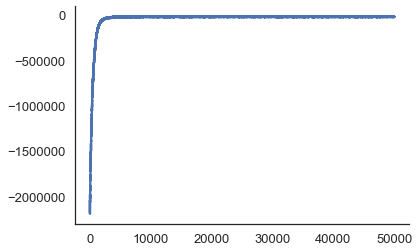

In [132]:
plt.plot(v_params.elbo_vals)
sns.despine()

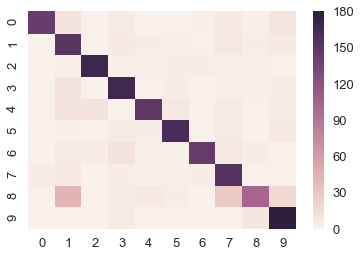

In [133]:
sns.heatmap(confusion_matrix(y_test, y_pred))

In [134]:
print("Accuracy on test: {}".format(accuracy_score(y_test, y_pred)*100))

Accuracy on test: 81.6337426588


## Hierarchical Neural Network: Learning Regularization from data

In [142]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape,

((16851, 1, 28, 28), (1873, 1, 28, 28), (16851,), (1873,))

In [141]:
from six.moves import zip
class GaussWeightWithHR(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        regularization = pm.HalfNormal('reg_hyper%d' % self.count, sd=1)
        return pm.Normal('w%d'%self.count, 
                         mu=0, 
                         sd=regularization, 
                         testval=np.random.normal(size=shape),
                         shape=shape)
minibatches = zip(
    create_minibatch(X_train, 500),
    create_minibatch(y_train, 500)
)


In [165]:
def run_fit_sample(likelihood, advi_iters=50000):
    #Train
    input_var.set_value(X_train[:500, ...])
    target_var.set_value(y_train[:500, ...])
    #v_params = pm.fit(n=20)

    trace = pm.sample()
    
    #Predict on test data
    input_var.set_value(X_test)
    target_var.set_value(y_test)
    
    ppc = pm.sample_ppc(trace, samples=100)
    y_pred = mode(ppc['out'], axis=0).mode[0, :]
    
    return v_params, trace, ppc, y_pred

In [157]:
with pm.Model() as hnn:
    likelihood = build_ann(GaussWeightWithHR())
    v_params, trace, ppc, y_pred = run_fit_sample(likelihood)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [1:01:37<00:00,  3.85s/it]/Users/vmullachery/anaconda/envs/dl2.7/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/Users/vmullachery/anaconda/envs/dl2.7/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.665976970964, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))

100%|██████████| 100/100 [00:04<00:00, 25.31it/s]


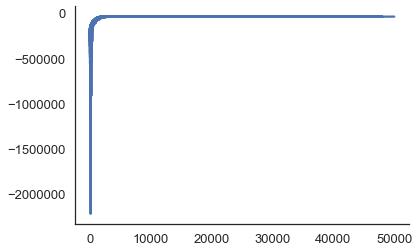

In [158]:
plt.plot(v_params.elbo_vals)
sns.despine()

In [159]:
print("Accuracy on test: {}".format(accuracy_score(y_test, y_pred)*100))

Accuracy on test: 62.9471436199


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e234b10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x120b365d0>]], dtype=object)

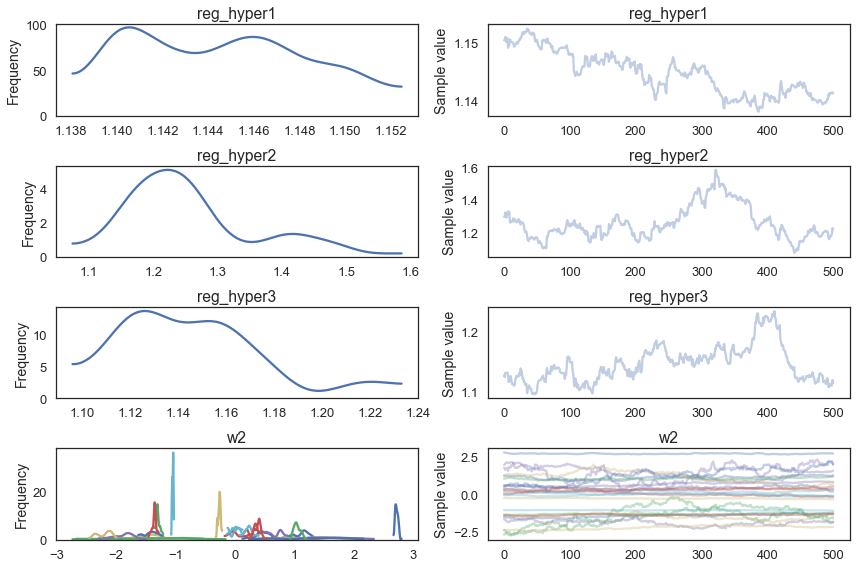

In [160]:
pm.traceplot(trace, varnames=['reg_hyper1', 'reg_hyper2', 'reg_hyper3', 'w2'])

In [161]:
trace.varnames

['reg_hyper1_log__',
 'w1',
 'reg_hyper2_log__',
 'w2',
 'reg_hyper3_log__',
 'w3',
 'reg_hyper4_log__',
 'w4',
 'reg_hyper5_log__',
 'w5',
 'reg_hyper6_log__',
 'w6',
 'reg_hyper1',
 'reg_hyper2',
 'reg_hyper3',
 'reg_hyper4',
 'reg_hyper5',
 'reg_hyper6']

## Now a Convolutional Net
All it requires is that we change the build_ann method to include convolutional layers

In [177]:
def build_ann_conv(init):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_var)
    network = lasagne.layers.Conv2DLayer(network, 
                                      num_filters=32, 
                                      filter_size=(5,5),
                                      nonlinearity=lasagne.nonlinearities.tanh,
                                      W=init
                                     )
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2,2))
    network = lasagne.layers.Conv2DLayer(network,
                                        num_filters=32,
                                        filter_size=(5,5),
                                        nonlinearity=lasagne.nonlinearities.tanh,
                                        W=init)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2,2))
    network = lasagne.layers.DenseLayer(network, 
                                        num_units=256, 
                                        nonlinearity=lasagne.nonlinearities.tanh,
                                        b=init,
                                        W=init
                                       )
    network = lasagne.layers.DenseLayer(network,
                                       num_units=10,
                                       nonlinearity=lasagne.nonlinearities.softmax,
                                       b=init,
                                       W=init)
    prediction = lasagne.layers.get_output(network)
    
    return pm.Categorical('out', prediction, observed=target_var)

In [178]:
with pm.Model() as cnn:
    likelihood = build_ann_conv(GaussWeightWithHR())
    v_params, trace, ppc, y_pred = run_fit_sample(likelihood)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
  6%|▌         | 55/1000 [2:51:55<120:21:50, 458.53s/it]/Users/vmullachery/anaconda/envs/dl2.7/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 0 samples.
  % (self._chain_id, n))
/Users/vmullachery/anaconda/envs/dl2.7/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:431: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
/Users/vmullachery/anaconda/envs/dl2.7/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



ValueError: low >= high

In [179]:
print("Accuracy on test: {}".format(accuracy_score(y_test, y_pred)*100))

Accuracy on test: 62.9471436199


### Unpredictability on categorical distribution measured using Chi-squared statistic
We don't simply use the ppc standard deviation

In [162]:
miss_class = np.where(y_test != y_pred)[0]
corr_class = np.where(y_test == y_pred)[0]
preds = pd.DataFrame(ppc['out']).T
chis = preds.apply(lambda x: chisquare(x).statistic, axis='columns')

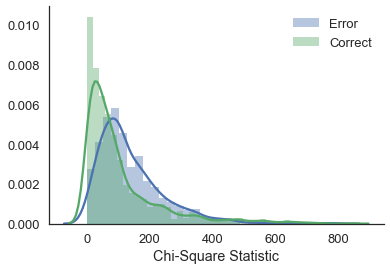

In [163]:
sns.distplot(chis.loc[miss_class].dropna(), label='Error')
sns.distplot(chis.loc[corr_class].dropna(), label='Correct')
plt.legend()
sns.despine()
plt.xlabel('Chi-Square Statistic')